<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Predict-one-stock-price-from-two-stock-price-sequence-using-LSTM" data-toc-modified-id="Predict-one-stock-price-from-two-stock-price-sequence-using-LSTM-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Predict one stock price from two stock price sequence using LSTM</a></span></li><li><span><a href="#[20pts]-Import-data" data-toc-modified-id="[20pts]-Import-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>[20pts] Import data</a></span></li><li><span><a href="#[40pts]-Data-preprocessing" data-toc-modified-id="[40pts]-Data-preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>[40pts] Data preprocessing</a></span></li><li><span><a href="#[20pts]-Define-and-compile-the-model-and-fit-the-data" data-toc-modified-id="[20pts]-Define-and-compile-the-model-and-fit-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>[20pts] Define and compile the model and fit the data</a></span></li><li><span><a href="#[20pts]-用-model-predict,-並用-matplotib-畫圖比較真實值和預言值" data-toc-modified-id="[20pts]-用-model-predict,-並用-matplotib-畫圖比較真實值和預言值-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>[20pts] 用 model predict, 並用 matplotib 畫圖比較真實值和預言值</a></span></li></ul></div>

# Predict one stock price from two stock price sequence using LSTM

請參考 RNN 課堂中用 LSTM 模型學習股票指數的代碼（`codes_in_class_week13.ipynb`），作出以下修正，並以此重新估算一次 Adj Close 的值。
1. 把輸入 LSTM 模型的特徵向量從原先只考慮 Adj Close 一項，更改為 (Adj Close, Volume) 共 2 個分量的特徵向量（feature vector）。然後把這樣的數據再利用 LSTM 模型分析一次。
1. 模型的 hyperparameter 大多數不用修改，但要注意因為輸入的特徵向量長度從 1 變為 2，輸入層（input layer）也需要修改。
1. 另外，由於我們仍然只關心 Adj Close 的值，因此輸出層的神經元數目保持為 1.

In [50]:
import yfinance

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# [20pts] Import data

先在你的電腦中用以下指令安裝 `yfinance`

In [86]:
#win + r
#cmd
#conda activate basicEnv
#pip install yfinance
#jupyter notebook

# [40pts] Data preprocessing

1. 分離出 Adj Close 和 Volume 的部份
1. 用 MinMaxScaler 調整數值範圍到 0 和 1 之間
1. 以60天為時序窗口的長度，生成數值序列 $x = (x_{1}, x_{2}, ..., x_{60})$, 其中 $x_{i}$ 為第 $i$ 天的特徵向量（這部份我在課堂上有強調，`codes_in_class_week13.ipynb` 文件中也有）。
Label（y 值）方面為任一序列結束後一天的 Adj Close，即 $x_{61}$。
1. 進行 Train-Test 分割

In [52]:
df = yfinance.download('^HSI')
df = df[df.Volume != 0]
df = df[["Adj Close","Volume"]]

scaler = MinMaxScaler(feature_range=(0, 1))
dfScaled = scaler.fit_transform(df.values)

windowLen = 60
features = []
labels = []
for index in range(windowLen, len(dfScaled)):
    features.append(dfScaled[(index - windowLen):index, :])
    labels.append(dfScaled[index, 0])
features = np.array(features)
labels = np.array(labels)

featuresTrain, featuresTest, labelsTrain, labelsTest = train_test_split(features, labels, test_size=0.2, shuffle=False)

[*********************100%***********************]  1 of 1 completed


# [20pts] Define and compile the model and fit the data

Model 的設計基本上跟隨上課時講的 LSTM 模型就可 

In [53]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(windowLen, 2)))
model.add(LSTM(30))
model.add(Dense(15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
model.fit(featuresTrain, labelsTrain, epochs=20)

Epoch 1/20
127/127 [==============================] - 4s 16ms/step - loss: 0.0109
Epoch 2/20
127/127 [==============================] - 2s 16ms/step - loss: 7.3163e-04
Epoch 3/20
127/127 [==============================] - 2s 16ms/step - loss: 6.7079e-04
Epoch 4/20
127/127 [==============================] - 2s 16ms/step - loss: 6.0243e-04
Epoch 5/20
127/127 [==============================] - 2s 16ms/step - loss: 5.7767e-04
Epoch 6/20
127/127 [==============================] - 2s 16ms/step - loss: 5.6281e-04
Epoch 7/20
127/127 [==============================] - 2s 17ms/step - loss: 4.9330e-04
Epoch 8/20
127/127 [==============================] - 2s 16ms/step - loss: 4.4487e-04
Epoch 9/20
127/127 [==============================] - 2s 16ms/step - loss: 4.1228e-04
Epoch 10/20
127/127 [==============================] - 2s 16ms/step - loss: 3.7852e-04
Epoch 11/20
127/127 [==============================] - 2s 16ms/step - loss: 3.6588e-04
Epoch 12/20
127/127 [==============================] - 2

# [20pts] 用 model predict, 並用 matplotib 畫圖比較真實值和預言值

1. 由於模型是用 MinMax rescale 過後的數值來訓練，因此該模型預言出來的 y 值也是被 rescaled 過的大小。
同學要用 MinMaxScaler 類的方法 `inverse_transform` 來做逆縮放。
不過，這個過程會引起一個問題，就是 MinMaxScaler 在前面 `fit_transform` 時處理的是長度為 2 的特徵向量，但現在 `inverse_transform` 是要處理的卻是長度為 1 的向量，這個差異會造成 error message。請同學想一下如何處理這個問題，使得 MinMaxScaler 能成功把 y_pred 轉換回正確的 scale。

1. 畫圖步驟在 `codes_in_class_week13.ipynb` 中也有

In [84]:
prediction = model.predict(featuresTest)
plusPrediction = np.ndarray((prediction.shape[0], 2))
for index in range(len(prediction)):
    plusPrediction[index] = np.append(prediction[index], 0)
prediction = scaler.inverse_transform(plusPrediction)[..., 0]

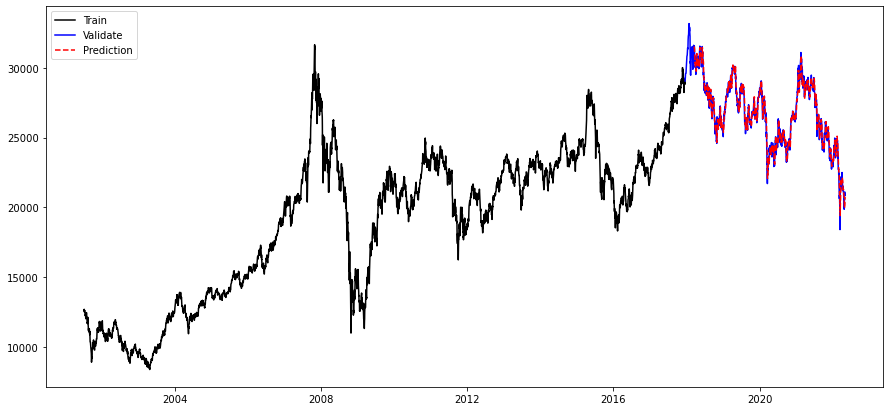

In [85]:
dfCompare = df.iloc[4051 + windowLen:].copy()[["Adj Close"]]
dfCompare['prediction'] = prediction
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(df[["Adj Close"]][:4051], 'k', label='Train')
ax.plot(df[["Adj Close"]][4051:], 'b', label='Validate')
ax.plot(dfCompare['prediction'], 'r--', label='Prediction')
ax.legend()